# Lens Center Calibratoin

Point coordinates measured manually with [paint.net](http://www.getpaint.net). Coordinates (x,y) according to standard image coordinates, which is different from normal cartesian (right handed) coordinates because it start on the upper left on the image.

The upper left pixel of the image is (1,1), the lower left is (1, height) and upper right pixel then (width,1).

In [1]:
global const height = 4020 
global const width = 6036 

6036

We have pricked four holes in the lens cap and turned it 8 times. The optimization method on this page also works with a different amount of points or turns, eg 3 circles and 4 turns. In that case just add/remove circ*i*x and circ*i*y vectors and/or their elements.

In [2]:
circ1x = [2375, 2392,2855,3448,3678,3645,3313,2658] #most inner circle x coordinates
circ1y = [1718,2361,2689,2546,2181,1738,1390,1319]  #most inner circle y coordinates
circ2x = [2301,2157,2635,3409,3790,3873,3567,2780]
circ2y = [1468,2277,2815,2802,2407,1851,1327,1153]
circ3x = [2282,1975,2434,3333,3449,4040,3777,2896]
circ3y = [1264,2170,2874,2995,2612,1978,1317,980]
circ4x = [2287,1862,2293,3268,3872,4140,3916,2987]
circ4y = [1119,2081,2906,3122,2751,2079,1328,868]

8-element Array{Int64,1}:
 1119
 2081
 2906
 3122
 2751
 2079
 1328
  868

In [3]:
using Winston

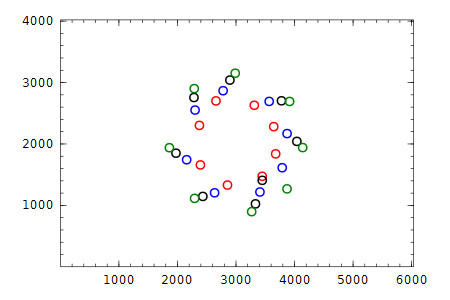

In [4]:
p=plot(circ1x, height-circ1y,"ro")
oplot(circ2x, height-circ2y,"bo")
oplot(circ3x, height-circ3y,"o")
oplot(circ4x, height-circ4y,"go")
xlim(1, width);ylim(1, height)

We are looking for the central point (cx, cy). There are 3 independent variables for each observed point (x,y) on each circle: distance ρ to the center, fase ϕ for each picture and offset δ per circle (because the 4 points are not on 1 line).

We will optimize over the central coordinates together with these 4 distances, 8 fases and 4 offsets.

First we create a custom Point type for easy calculation:

In [5]:
type Point
    x::Float64 #column index! float b/c optimization
    y::Float64 #row index!
end
#We encode the observed points in 1 Matrix of points
cx = [circ1x circ2x circ3x circ4x]
cy = [circ1y circ2y circ3y circ4y]
global Nϕ = size(cx, 1) #count of fases (for each picture of a turn)
global Nρ = size(cx, 2) #count of angles and circles (for number of holes in cap)
points = Point[Point(cx[i,j],cy[i,j]) for i = 1:Nϕ, j = 1:Nρ] 

8x4 Array{Point,2}:
 Point(2375.0,1718.0)  Point(2301.0,1468.0)  …  Point(2287.0,1119.0)
 Point(2392.0,2361.0)  Point(2157.0,2277.0)     Point(1862.0,2081.0)
 Point(2855.0,2689.0)  Point(2635.0,2815.0)     Point(2293.0,2906.0)
 Point(3448.0,2546.0)  Point(3409.0,2802.0)     Point(3268.0,3122.0)
 Point(3678.0,2181.0)  Point(3790.0,2407.0)     Point(3872.0,2751.0)
 Point(3645.0,1738.0)  Point(3873.0,1851.0)  …  Point(4140.0,2079.0)
 Point(3313.0,1390.0)  Point(3567.0,1327.0)     Point(3916.0,1328.0)
 Point(2658.0,1319.0)  Point(2780.0,1153.0)     Point(2987.0,868.0) 

In [6]:
#define euclidean distance between points
dist(a::Point, b::Point) = sqrt((a.x-b.x)^2 + (a.y-b.y)^2)
# test `dist` method
c = Point(ifloor(width/2),ifloor(height/2))
dist(points[1,1],c)

706.1961483893834

In [7]:
# also define method for the angle between points
angle(a::Point, b::Point) = atan2(a.y-b.y, b.x-a.x)
angle(c, points[1,1])

2.7153167366818782

Create fit function as sum of squared errors. 

In [8]:
function sse(inp::Vector)
    # all parameters in asingle `inp` vector
    cx,cy = inp[1:2]
    c = Point(cx,cy)
    ρ = inp[3 : Nρ+2]
    δ = inp[3+Nρ : 2Nρ+2]
    ϕ = inp[3+2Nρ : end]
    
    se = Float64[] #squared errors
    for i = 1:Nρ
        #normalize this squared error with the squared typical radius
        push!(se, sum([(ρ[i] - dist(c, points[n, i]))^2 for n = 1:Nϕ])/(height^2/4))
    end
    for i = 1:Nϕ
        push!(se, sum([(ϕ[i] + δ[n] - angle(c,points[i, n]))^2 for n = 1:Nρ]))
    end    
    sum(se)
end

sse (generic function with 1 method)

In [9]:
# For the starting point of the opimization we estimate the initial parameters from the inner circle.
function initsse(c::Point, points::Matrix{Point})
    init = zeros(2 + 2Nρ + Nϕ)
    init[1:2] = [c.x, c.y]
    for i = 1:Nρ
        init[2+i] = dist(c, points[1,i])
        #offset
        init[2+Nρ+i] = angle(c, points[1,i]) - angle(c,points[1,1])
    end
    for i = 1:Nϕ
        init[2+2Nρ+i] = angle(c, points[i,1])
    end
    init
end
initsse(c, points)'

1x18 Array{Float64,2}:
 3018.0  2010.0  706.196  898.806  1047.96  …  0.409311  1.12669  2.05109

In [10]:
sse(initsse(c, points))

0.1378493050175995

In [11]:
using Optim

In [12]:
# We optimize using the Nelder-Mead downhill simplex algorithm, 
# the default for functions without a derivate explicetly defined.
@time res = optimize(sse, initsse(c, points),iterations=10_000) 

elapsed time: 1.395848529 seconds (203992520 bytes allocated, 5.54% gc time)


Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3018.0,2010.0,706.1961483893834,898.8064307736121,1047.9561059510079,1152.4938177708373,0.0,-0.22100799538162574,-0.36586978241085744,-0.4574477984452092,2.7153167366818782,-2.630569416337925,-1.8063970085127503,-0.8946917490529358,-0.2535163425510572,0.4093105855746326,1.1266902039217643,2.0510899297236125]
 * Minimum: [2974.2044337588068,2008.8798444336874,735.4546838146354,911.3577998095559,1025.6855566385061,1165.4153196392465,-1.0070920285499083,-1.224886409187287,-1.412399971561813,-1.4647138621677773,3.7028918857180098,-1.5926252789453392,-0.7382820166355788,0.16436333358357105,0.7052867692359692,1.4089501186117848,2.092810746074935,3.027313285828874]
 * Value of Function at Minimum: 0.083665
 * Iterations: 3458
 * Convergence: true
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < NaN: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function C

In [13]:
@show lenscenter = Point(int(res.minimum[1:2])...)

lenscenter = Point(int(res.minimum[1:2])...) => Point(2974.0,2009.0)


Point(2974.0,2009.0)

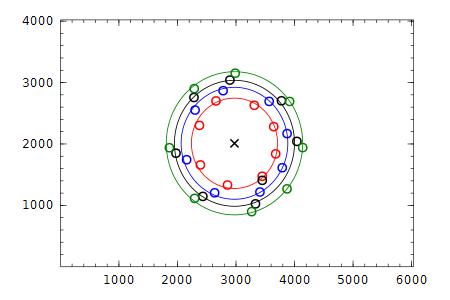

In [14]:
function plotresults(points, c::Point, ρs)
    p=plot([c.x], [c.y], "x")
    colors = ["r","b","k","g"]
    ϕvec = linspace(0, 2π,100)
    for i = 1:Nρ
        oplot([points[m,i].x for m=1:size(points,1)], height-[points[m,i].y for m=1:size(points,1)],"o"*colors[i])
        oplot(c.x + ρs[i]*cos(ϕvec), height-c.y + ρs[i]*sin(ϕvec), colors[i])
    end    
    xlim(1, width);ylim(1, height)
    p
end
plotresults(points, lenscenter,res.minimum[3:6])

In [15]:
@show lenscenter.x
@show lenscenter.y

lenscenter.x => 2974.0
lenscenter.y => 2009.0


2009.0